# Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow
**Concepts Tools and Techniques to Build Intelligent Systems**  
  
My notes along the way.  
Bonnie Cooper

<br>

## Chapter 1: The Machine Learning Landscape

**Machine Learning is**....  

* the science/art of programming computers so that they can learn from data
* the field of study that gives computers the ability to learn without being explicitly programmed
* A computer program is said to learn from experience E with respect to some task T and some performance measure P, if its performance on T as measured by P inproves with experience E.

**Human Supervision**  

* Supervised - the training set that is fed to the algorithm contains the solution (labels). For example, classification, linear regression, kNN, logistic regression, SVM, Decision Trees and Random Forests, Neural Networks
* Unsupervised - the training data is unlabelled. For example: clustering, anomoly/novelty detection, dimentionality reduction (e.g. PCA), Association rule learning
* Semisupervised - partially labelled data and are generally combinations of supervised and unsupervised algotithms. For example, deep belief networks
* Reinforcement Learning - the learining system can observe the environment, select actions to perform. It then can get rewards for good outcomes, penalties for bad outcomes or both. From these new outcomes, the system updates it's strategy/policy accordingly.

**Batch (offline) Learning** - the system is incapable of learning incrementally: it must be trained using all the available data typically offline. The system is trained, and then it is launched intp production and runs without learning anymore.  
**Online Learning** - the system is trained incrementally by feeding it data instances squentially, either individual instances or small groups called *mini-batches*. Each learning step is fast and cheap, so the system can learn about new data on the fly.  

**Generalize** - how does the model/system perform with new data?  
**Instance-based Learning** - the system learns the examples by heart, then generalizes to new cases by using a similarity measure to compare them to the learned examples.  
**Model-based Learning** - build a model of the examples and use the model to make predictions on new data. Steps include: model selection, using a performance measure to evaluate model performance (utility or cost function), train the model, then run on unseen data.  

<br>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

In [3]:
# load the data
url_oecd = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/lifesat/oecd_bli_2015.csv'
url_gdp = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/lifesat/gdp_per_capita.csv'

oecd_bli = pd.read_csv( url_oecd, thousands=',' )
gdp_per_capita = pd.read_csv( url_gdp, thousands=',', delimiter='\t', encoding='latin1', na_values='n/a' )

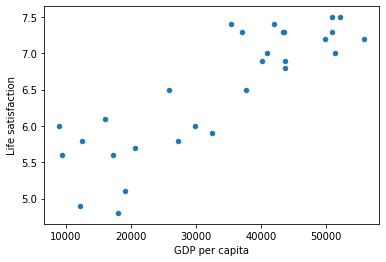

In [4]:
def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]

# prepare the data
country_stats = prepare_country_stats( oecd_bli, gdp_per_capita )
X = np.c_[ country_stats[ "GDP per capita" ] ]
y = np.c_[ country_stats[ "Life satisfaction" ] ]

# visualize the data
country_stats.plot( kind = 'scatter', x = 'GDP per capita', y = 'Life satisfaction' )
plt.show()

In [5]:
# linear regression prediction
model = sklearn.linear_model.LinearRegression()
model.fit( X,y )

# make a prediction for Cyprus (gdp = 22587)
X_new = [[22587]]
print( model.predict( X_new ) )

[[5.96242338]]


In [6]:
# kNN prediction
import sklearn.neighbors
model = sklearn.neighbors.KNeighborsRegressor( n_neighbors=3 )
model.fit( X,y )

# make a prediction for Cyprus (gdp = 22587)
X_new = [[22587]]
print( model.predict( X_new ) )

[[5.76666667]]


<br>

Typical ML Workflow:  

* Study the Data
* Select the Model(s)
* Train the Model
* Make Predictions on New Cases

Things that can go wrong:  

* bad algorithm
    - **overfitting** - the model performs very well on training data, but fails to generalize to new instances. solution: **regularization** - make the model simpler to reduce the risk of overfitting
    - **underfitting** - occurs when the model is too simple to learn the underlying structure of the data.
* bad data
    - insufficient quantity of training data
    - nonrepresentative training data
    - poor quality (noisy/incomplete) data
    - irrelevant features

Testing and Validating:  

1. split the data in two sets: train & test
2. train your model on a training set and then test it on the test set
    - **hyperparameter tuning** - might need to sample multiple values for model parameter(s). it is best practice to hold out a portion of the training data as a validation set to evaluate model parameter performance
3. evaluate model performance with the test set: generalization error  

if the training error is low but the test error is high, this indicates the model is overfit to the training set.
<br>

<br>

## Chapter 2: End-to-End Machine Learning Project

<br>

Use California Census data to build a model of housing prices in the state.  

Follow the Machine Learning Project Checklist:  

1. Frame the problem and look at the big picture
2. Get the data
3. Explore the data to gain insights
4. Prepare the data to better expose the underlying data patterns to Machine Learning Algorithms
5. Explore many different models and shortlist the best ones
6. Fine-tune your models and combine them into a great solution
7. Present your solution
8. Launch, monitor and maintain your solution

<br>

**Framing the Problem**: 
    
* exactly what is the business objective?
    - ex: the model should predict the district's median housing price and the projections will be fed to another machine learning system along with many other signals 
* what does the current solution look like? 
    - a reference for baseline performance
* select a performance metric
    - ex: RMSE for regression, or the cost function measured on the set of examples using your hypothesis *h*    $$\mbox{RMSE}(\mathbf{X},h)=\sqrt{\frac{1}{m}\sum^m_{i=1}(h(x^{(i)})-y^{(i)})^2}$$
    - ex: MAE for regression with outliers   $$\mbox{MAE}(\mathbf{X},h)=\frac{1}{m}\sum^m_{i=1}|h(x^{(i)})-y^{(i)}|$$
* check the assumptions
    
**pipeline** a sequence of data components  


In [7]:
#setup
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [8]:
#data
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [9]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
#an overview of the dataframe
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [11]:
#look at the categorical feature `ocean_proximity`
housing[ 'ocean_proximity' ].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [12]:
#look at the numeric attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


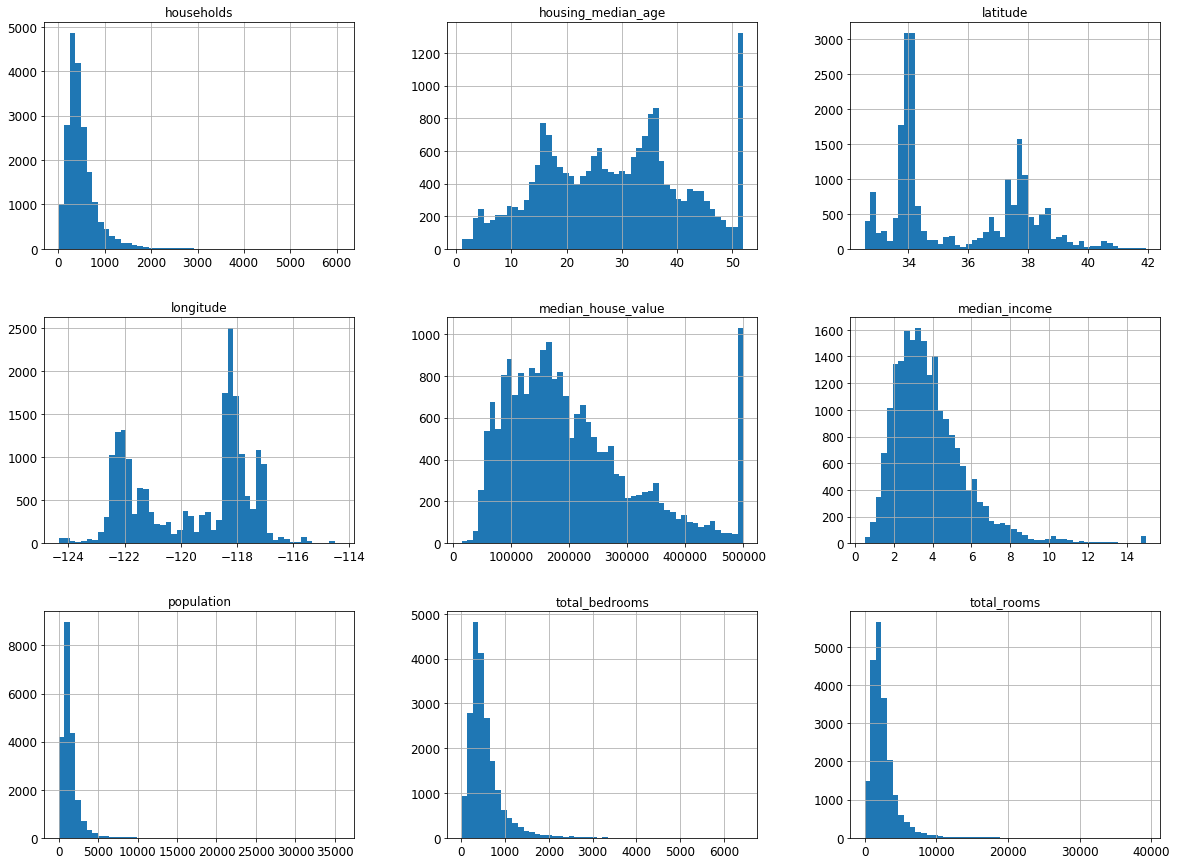

In [13]:
#visualize numeric attributes with histogrmas
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist( bins=50, figsize=(20,15 ) )
plt.show()

<br>

<font color=red>Wait! Before you look at the data any further, you need to create a text set, put it aside, and never look at it.</font>  

Pick some instances of the data at random, typically 20% of the dataset (or less if your dataset is very large), and set them aside.

<br>

In [14]:
def split_train_test( data, test_ratio ):
    shuffled_indices = np.random.permutation( len( data ) )
    test_set_size = int( len( data ) * test_ratio )
    test_indices = shuffled_indices[ :test_set_size ]
    train_indices = shuffled_indices[ test_set_size: ]
    return data.iloc[ train_indices ], data.iloc[ test_indices ]

In [15]:
train_set, test_set = split_train_test( housing, 0.2 )
print( len( train_set ) )
print( len( test_set ) )

16512
4128


In [16]:
# a stable train/test split
from zlib import crc32

def test_set_check( identifier, test_ratio ):
    return crc32( np.int64( identifier ) ) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id( data, test_ratio, id_column ):
    ids = data[ id_column ]
    in_test_set = ids.apply( lambda id_: test_set_check( id_, test_ratio ) )
    return data.loc[ ~in_test_set ], data.loc[ in_test_set ]

In [17]:
housing_with_id = housing.copy()
housing_with_id[ 'id' ] = housing[ "longitude" ]*1000 + housing[ "longitude" ]
train_set, test_set = split_train_test_by_id( housing_with_id, 0.2, "id" )
print( len( train_set ) )
print( len( test_set ) )

16172
4468


In [18]:
#alternatively, can use sklearns method:
from sklearn.model_selection import train_test_split
tarin_set, test_set = train_test_split( housing, test_size = 0.2, random_state = 42 )

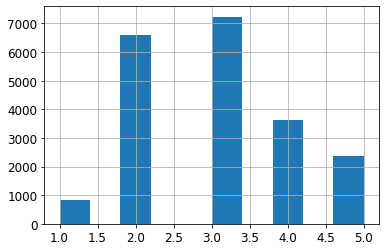

In [19]:
housing[ "income_cat" ] = pd.cut( housing[ "median_income" ],
                                bins = [ 0., 1.5, 3.0, 4.5, 6., np.inf ],
                                labels = [ 1,2,3,4,5 ] )
housing[ "income_cat" ].hist()
plt.show()

<br>

we observe that the instances do not have equal likelihood across the median income categories.  
to avoid **sampleing bias** we will use a stratefied sampling method

<br>

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit( n_splits = 1, test_size = 0.2, random_state = 42 )
for train_index, test_index in split.split( housing, housing[ "income_cat" ] ):
    strat_train_set = housing.loc[ train_index ]
    strat_test_set = housing.loc[ test_index ]

print( "stratefied" )    
print( strat_test_set[ "income_cat" ].value_counts() / len( strat_test_set ) )
print( 'native' )
print( housing[ "income_cat" ].value_counts() / len( housing ) )

stratefied
3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64
native
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64


In [21]:
#remove income_cat (redundant feature)
for set_ in ( strat_train_set, strat_test_set ):
    set_.drop( "income_cat", axis=1, inplace=True )

<br>

### Discover and Visualize the Data to Gain Insights

<br>

In [22]:
# work with the train set
housing = strat_train_set.copy()


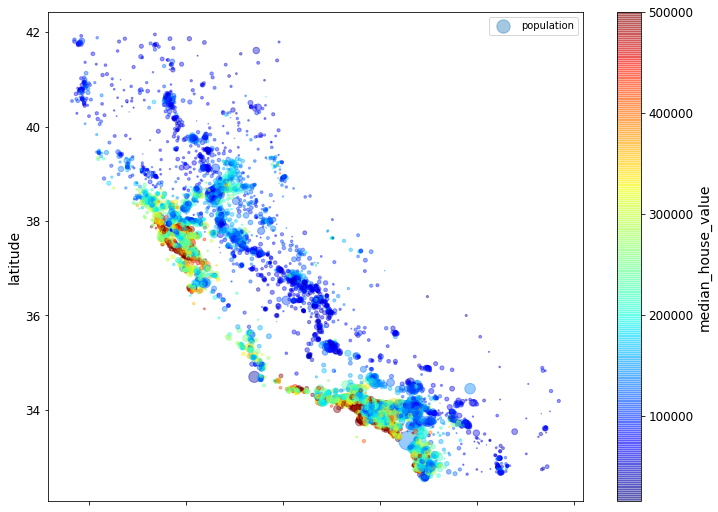

In [23]:
housing.plot( kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
            s = housing[ "population"]/100, label = "population", figsize = (12,9),
            c = "median_house_value", cmap = plt.get_cmap( "jet" ), colorbar = True )
plt.show()

In [24]:
corr_matrix = housing.corr()
corr_matrix[ "median_house_value" ].sort_values( ascending = False )

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

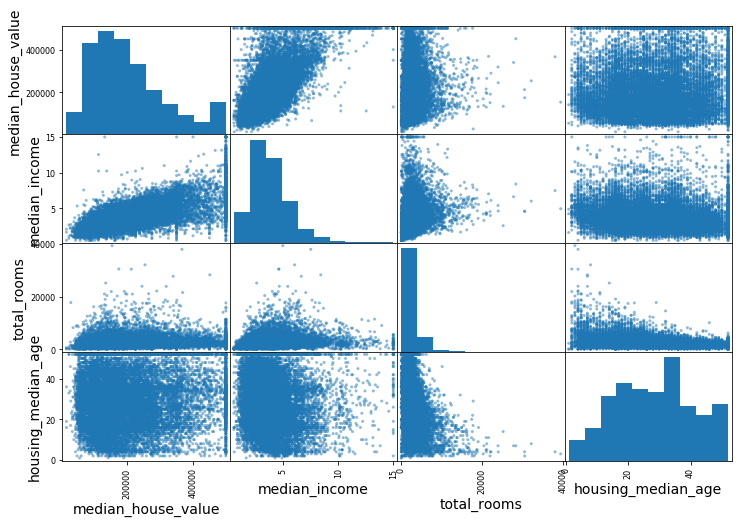

In [25]:
#visually inspect for correlations
from pandas.plotting import scatter_matrix
attributes = [ "median_house_value", "median_income", "total_rooms", "housing_median_age" ]
scatter_matrix( housing[ attributes ], figsize = ( 12,8 ) )
plt.show()

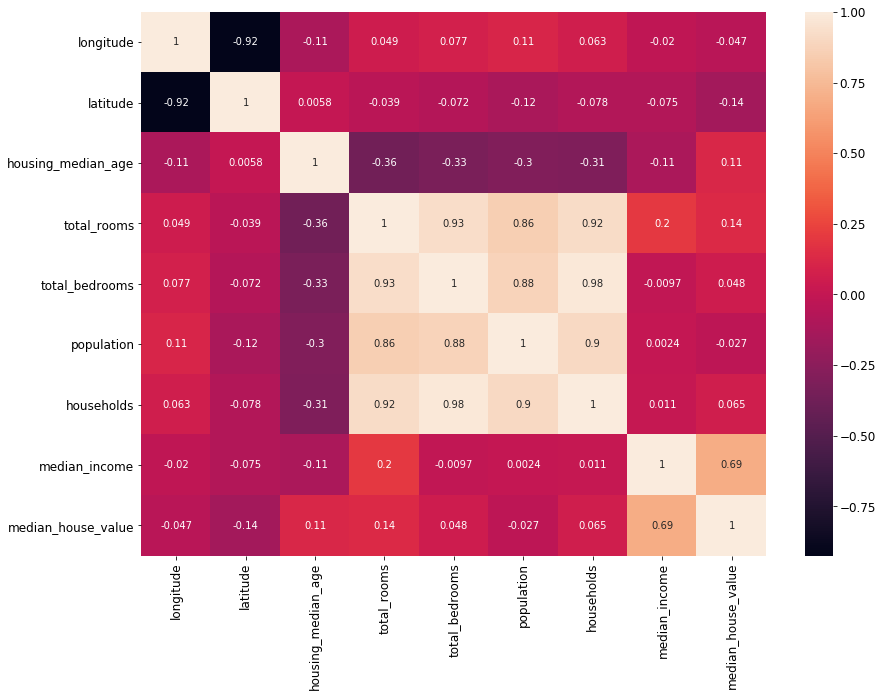

In [26]:
import seaborn as sns

Var_Corr = housing.corr()
# plot the heatmap and annotation on it
plt.figure(figsize=(14, 10))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, 
            yticklabels=Var_Corr.columns, annot=True)
plt.show()

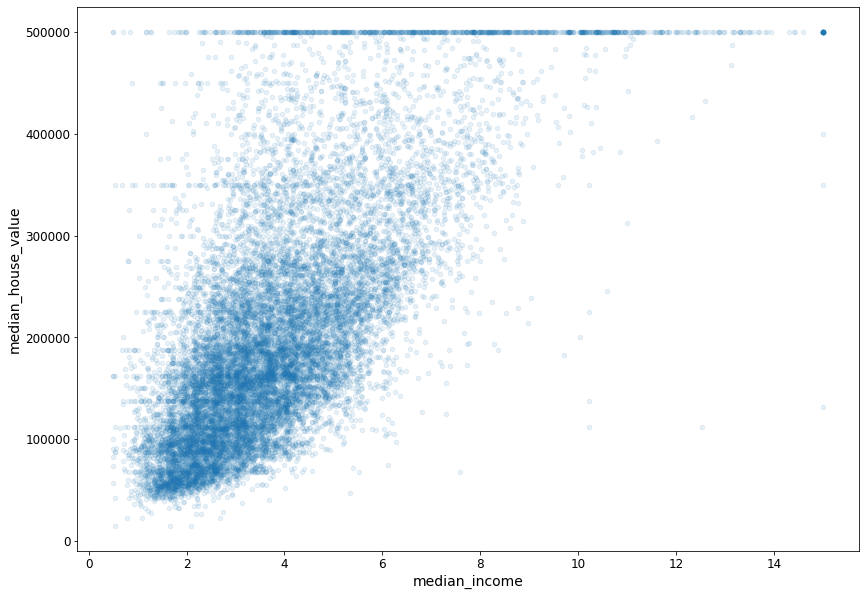

In [27]:
housing.plot( kind = "scatter", x = "median_income", y = "median_house_value", 
             alpha = 0.1, figsize=(14, 10) )
plt.show()

In [28]:
# experimenting with attribute combinations
housing[ "rooms_per_household" ] = housing[ "total_rooms" ]/housing[ "households" ]
housing[ "bedrooms_per_room" ] = housing[ "total_bedrooms" ]/housing[ "total_rooms" ]
housing[ "population_per_household" ] = housing[ "population" ]/housing[ "households" ]

In [31]:
corr_matrix = housing.corr()
corr_matrix[ "median_house_value" ].sort_values( ascending = False )

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

<br>

### Preparing the Data for ML Algorithms

<br>

In [33]:
#make a fresh copy of feature variables and taget
housing = strat_train_set.drop( "median_house_value", axis=1 )
housing_labels = strat_train_set[ "median_house_value"].copy()

In [34]:
#Data cleaning
#missing values
housing.dropna( subset = [ "total_bedrooms" ] )
housing.drop( "total_bedrooms", axis = 1 )
median = housing[ "total_bedrooms" ].median()
housing[ "total_bedrooms" ].fillna( median, inplace = True )

In [35]:
#imputing values w/sklearn
from sklearn.impute import SimpleImputer
imputer = SimpleImputer( strategy = "median" )
housing_num = housing.drop( "ocean_proximity", axis = 1) #SimpleImputer needs just numeric features
imputer.fit( housing_num )

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [36]:
print( imputer.statistics_ )
print( housing_num.median() )

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2119.5000
total_bedrooms         433.0000
population            1164.0000
households             408.0000
median_income            3.5409
dtype: float64


In [38]:
#can use the trained imputer to transform other data (i.e. training set)
X = imputer.transform( housing_num )
house_tr = pd.DataFrame( X, columns = housing_num.columns,
                       index = housing_num.index )
house_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [39]:
#looking at the text attribute
housing_cat = housing[ "ocean_proximity" ]
housing_cat.head( 10 )

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [45]:
#convert from char to numeric representation
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform( housing_cat.values.reshape(-1,1) )
housing_cat_encoded[ :10 ]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [46]:
#show the corresponding category labels
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [49]:
#better for unordered categories
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform( housing_cat.values.reshape(-1,1) )
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [57]:
# a custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder( BaseEstimator, TransformerMixin ):
    def __init__( self, add_bedrooms_per_room = True ):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit( self, X, y=None ):
        return self
    def transform( self,X ):
        rooms_per_household = X[ :,rooms_ix ] / X[ :,households_ix ]
        population_per_household = X[ :,population_ix ] / X[ :,households_ix ]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[ :,bedrooms_ix ] / X[ :,rooms_ix ]
            return np.c_[ X, rooms_per_household, population_per_household,
                        bedrooms_per_room ]
        else:
            return np.c_[ X, rooms_per_household, population_per_household ]

In [59]:
attr_adder = CombinedAttributesAdder( add_bedrooms_per_room = False )
housing_extra_attribs = attr_adder.transform( housing.values )

<br>

**features scaling** ML algorithms don't perform well when the input numerical attributes have different scales  

* **min-max scaling** - `MinMaxScaler` - values are shifted and rescaled such that they end up ranging from 0 to 1. subtract the min value and divide by the max
* **standardization** - `StandardScaler` -stadardizes values to have a mean of 0. this is done by subtracting the mean values and dividing by the standard deviation.

<br>

In [60]:
# Transformatio Pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline( [
    ( 'imputer', SimpleImputer( strategy = 'median' ) ),
    ( 'attribs_adder', CombinedAttributesAdder() ),
    ( 'std_scaler', StandardScaler() ),
] )

In [62]:
housing_num_tr = num_pipeline.fit_transform( housing_num )

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [63]:
# Transformation Pipeline that handles both num and cat simultaneously
from sklearn.compose import ColumnTransformer

num_attribs = list( housing_num )
cat_attribs = [ 'ocean_proximity' ]

full_pipeline = ColumnTransformer( [
    #( name, transformer, list(columns) )
    ( 'num', num_pipeline, num_attribs ),
    ( 'cat', OneHotEncoder(), cat_attribs ),
] )
#can use the remainder = 'passthrough' if there are columns that should remain untouched

In [66]:
housing_prepared = full_pipeline.fit_transform( housing )

<br>

### Select & Train a Model

<br>

In [68]:
# a simple linear regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit( housing_prepared, housing_labels )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [69]:
# fit the model to the data
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict( housing_prepared )
lin_mse = mean_squared_error( housing_labels, housing_predictions )
lin_rmse = np.sqrt( lin_mse )
lin_rmse

68628.19819848922

In [70]:
# a decision tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit( housing_prepared, housing_labels )

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [75]:
# cross-validation of the tree
from sklearn.model_selection import cross_val_score

scores = cross_val_score( tree_reg, housing_prepared, housing_labels,
                        scoring = "neg_mean_squared_error", cv = 10 )
tree_rmse_scores = np.sqrt( -scores )

In [76]:
# visualize the results
def display_scores( scores ):
    print( "Scores:", scores )
    print( "Mean:", scores.mean() )
    print( "Standard deviation", scores.std() )
    
display_scores( tree_rmse_scores )

Scores: [67955.52272124 66832.94214304 72035.74663073 69180.92884406
 70524.39035835 74926.08356551 70370.50216506 71957.00107648
 77180.779762   70577.94280585]
Mean: 71154.1840072325
Standard deviation 2934.448891655373


In [77]:
display_scores( tree_rmse_scores )

Scores: [67955.52272124 66832.94214304 72035.74663073 69180.92884406
 70524.39035835 74926.08356551 70370.50216506 71957.00107648
 77180.779762   70577.94280585]
Mean: 71154.1840072325
Standard deviation 2934.448891655373


In [79]:
# compute the scores for the linear regression model
lin_scores = cross_val_score( lin_reg, housing_prepared, housing_labels,
                             scoring = "neg_mean_squared_error", cv = 10 )
lin_rmse_scores = np.sqrt( -lin_scores )
display_scores( lin_rmse_scores )

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation 2731.6740017983443


<br>

The random forest model is overfitting so badly that the linear regression model outperforms it. Now to try a random forest....

<br>

In [81]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit( housing_prepared, housing_labels )
scores = cross_val_score( forest_reg, housing_prepared, housing_labels,
                        scoring = "neg_mean_squared_error", cv = 10 )
forest_rmse_scores = np.sqrt( -scores )
display_scores( forest_rmse_scores )

Scores: [49680.44437125 47392.90707569 49922.99769539 52279.3596267
 49770.48822858 53151.61873609 48880.53616754 48040.5874826
 53279.91428437 50102.20412278]
Mean: 50250.10577909839
Standard deviation 1931.8666197002506


In [82]:
#saving models (hyperparameters and trained parameters)
import joblib
joblib.dump( forest_reg, "forest_reg.pkl" )

#loading saved models
loaded_forest_reg = joblib.load( "forest_reg.pkl" )

In [84]:
loaded_forest_reg

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

<br>

### Fine Tuning Models
tuning hyperparameters  

**grid search** try out different values for select hyperparameters  
when you have no idea what value a hyperparameter should have, a simple approach is to try out consecutive powers of 10.  

<br>

In [87]:
from sklearn.model_selection import GridSearchCV

param_grid = [ 
    { 'n_estimators': [3,10,30], 'max_features': [2,4,6,8] },
    { 'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4] }
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV( forest_reg, param_grid, cv = 5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score = True )

grid_search.fit( housing_prepared, housing_labels )

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [89]:
print( grid_search.best_params_ )
print( grid_search.best_estimator_ )

{'max_features': 6, 'n_estimators': 30}
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [90]:
# evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip( cvres["mean_test_score"], cvres["params"]):
    print( np.sqrt(-mean_score), params)

64991.67573439946 {'max_features': 2, 'n_estimators': 3}
55741.94675931659 {'max_features': 2, 'n_estimators': 10}
52988.44249918449 {'max_features': 2, 'n_estimators': 30}
60047.867405160076 {'max_features': 4, 'n_estimators': 3}
52864.5835692249 {'max_features': 4, 'n_estimators': 10}
50680.87000700277 {'max_features': 4, 'n_estimators': 30}
59283.39913613561 {'max_features': 6, 'n_estimators': 3}
52397.97231799319 {'max_features': 6, 'n_estimators': 10}
49988.036648399655 {'max_features': 6, 'n_estimators': 30}
59534.6182353736 {'max_features': 8, 'n_estimators': 3}
52734.98097672237 {'max_features': 8, 'n_estimators': 10}
50009.997917230714 {'max_features': 8, 'n_estimators': 30}
62071.96787475377 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54386.183977013134 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60809.850434838045 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52839.04468262018 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [93]:
#analyzing model errors
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = [ "rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room" ]
cat_encoder = full_pipeline.named_transformers_[ "cat" ]
cat_one_hot_attribs = list( cat_encoder.categories_[0] )
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted( zip( feature_importances, attributes ), reverse = True )

[(0.3299423143917114, 'median_income'),
 (0.14573268131085543, 'INLAND'),
 (0.10778033461825795, 'pop_per_hhold'),
 (0.07704208392303032, 'longitude'),
 (0.06983054155865073, 'rooms_per_hhold'),
 (0.06656311107366968, 'bedrooms_per_room'),
 (0.0662013919137277, 'latitude'),
 (0.04052179612578014, 'housing_median_age'),
 (0.01754563854179284, 'population'),
 (0.01682988272342029, 'households'),
 (0.016599399304843023, 'total_bedrooms'),
 (0.016452224390893815, 'total_rooms'),
 (0.013631698043238532, '<1H OCEAN'),
 (0.008212916107864803, 'NEAR OCEAN'),
 (0.006982827813843926, 'NEAR BAY'),
 (0.00013115815841947164, 'ISLAND')]

<br>

### Evaluate on the test set

<br>

In [94]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop( "median_house_value", axis = 1 )
y_test = strat_test_set[ "median_house_value"].copy()
X_test_prepared = full_pipeline.transform( X_test )

final_predictions = final_model.predict( X_test_prepared )
final_mse = mean_squared_error( y_test, final_predictions )
final_rmse = np.sqrt( final_mse )

In [95]:
#how precise is the estimate?
from scipy import stats
confidence = 0.95
squared_errors = ( final_predictions - y_test )**2
np.sqrt( stats.t.interval( confidence, len( squared_errors ) - 1,
                         loc = squared_errors.mean(),
                         scale = stats.sem( squared_errors )))

array([45816.58257333, 49657.83777351])

<br>

### Chapter 2 Exercises

<br>

In [96]:
#try an SVM
from sklearn.svm import SVR
svr_reg = SVR()
svr_reg.fit( housing_prepared, housing_labels )
scores = cross_val_score( svr_reg, housing_prepared, housing_labels,
                        scoring = "neg_mean_squared_error", cv = 10 )
svr_rmse_scores = np.sqrt( -scores )
display_scores( svr_rmse_scores )

Scores: [111389.0681902  119541.25938571 116957.62830414 120447.19932481
 117618.15904234 122309.10351544 117634.40230741 121469.713921
 120343.01369623 118017.12860651]
Mean: 118572.66762937943
Standard deviation 2936.8775867949425


In [99]:
import time
start = time.process_time()

svr_reg = SVR()
parameters = [
        {'kernel': ['linear'], 'C': [10., 100., 1000., 10000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 10., 100., 1000.0],
         'gamma': [0.01, 0.1, 1.0, 10.0]},
    ]

grid_search = GridSearchCV( svr_reg, parameters, cv = 5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score = True )

grid_search.fit( housing_prepared, housing_labels )
print(time.process_time() - start)

881.23567532


In [98]:
print( grid_search.best_params_ )
print( grid_search.best_estimator_ )

{'C': 10, 'kernel': 'linear'}
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


<br>

## Chapter 3: Classification

<br>

**MNIST**: the 'hello world' of machine learning data sets

<br>

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml( 'mnist_784', version = 1 )
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
#take a look at the target and data arrays
X, y = mnist["data"], mnist['target']
print( X.shape )
print( y.shape )

(70000, 784)
(70000,)


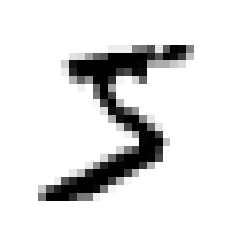

In [8]:
#take a look at one of the images
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape( 28, 28 )

plt.imshow( some_digit_image, cmap = "binary" )
plt.axis( 'off' )
plt.show()

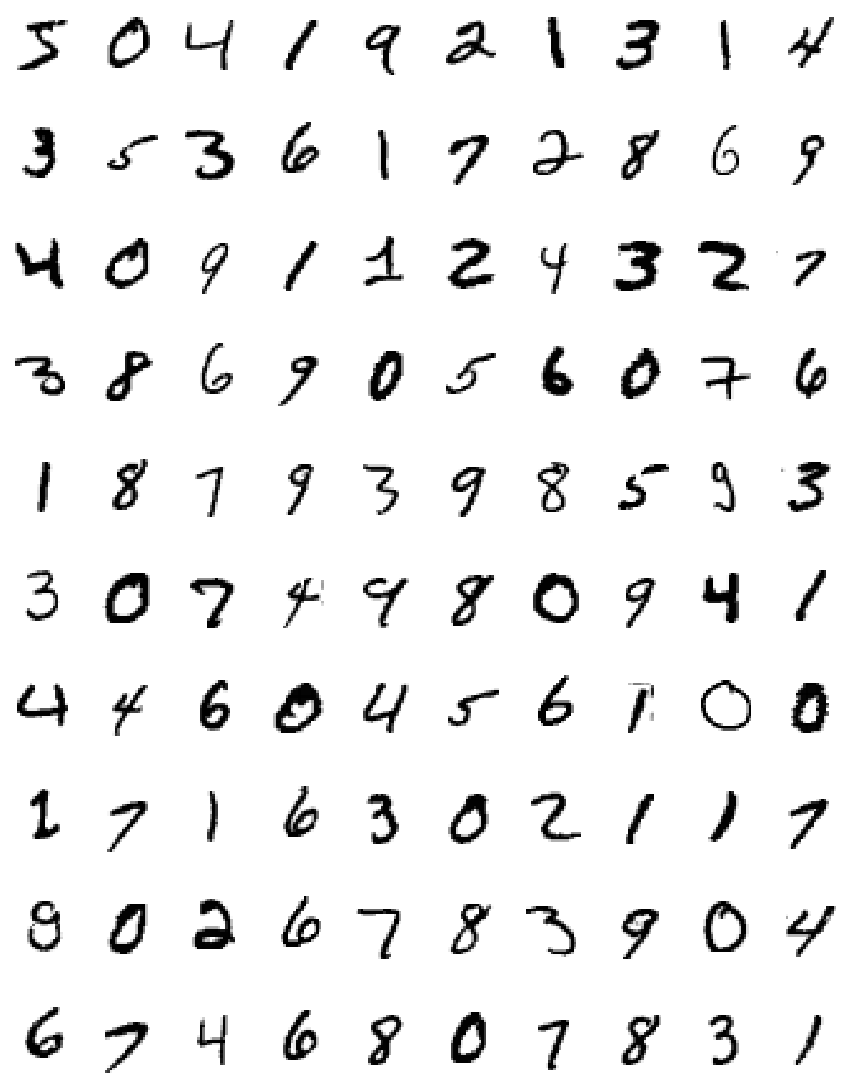

In [26]:
fig = plt.subplots(figsize=(15, 20))
    #plt.subplots_adjust( hspace = 0.1 )
    
a = 10  # number of rows
b = 10  # number of columns

for character in range(0,100):
    some_digit = X[character]
    plt.subplot( a,b,character + 1 )
    some_digit_image = some_digit.reshape( 28, 28 )
    plt.imshow( some_digit_image, cmap = "binary" )
    plt.axis( 'off' )


In [35]:
#print some labels
y = y.astype( np.uint8 )
y[0:100]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

In [36]:
# train/test split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

<br> 

### training a binary classifier

<br>

In [37]:
#a binary (T/F) classifier to identify whether a digit if a 5 (T) or not a 5 (F)
y_train_5 = ( y_train == 5 )
y_test_5 = ( y_test == 5 ) 

In [89]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier( random_state = 42 )
sgd_clf.fit( X_train, y_train_5 )

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:
# use the classifier to detect the number 5
sgd_clf.predict( some_digit.reshape(1, -1) )

array([False])

In [51]:
# implementing cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold( n_splits = 3, shuffle = True )

for train_index, test_index in skfolds.split( X_train, y_train_5 ):
    clone_clf = clone( sgd_clf )
    X_train_folds = X_train[ train_index ]
    y_train_folds = y_train_5[ train_index ]
    X_test_fold = X_train[ test_index ]
    y_test_fold = y_train_5[ test_index ]
    
    clone_clf.fit( X_train_folds, y_train_folds )
    y_pred = clone_clf.predict( X_test_fold )
    n_correct = sum( y_pred == y_test_fold )
    print( n_correct/len( y_pred ) )

0.9587
0.93915
0.9659


In [50]:
# use sklearn's cross-validation
from sklearn.model_selection import cross_val_score
cross_val_score( sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy' )

array([0.95035, 0.96035, 0.9604 ])

In [53]:
# compare our model's accuracy to a baseline model that categorizes everything as False
from sklearn.base import BaseEstimator

class Never5Classifier( BaseEstimator ):
    def fit( self, X, y = None ):
        return self
    def predict( self, X ):
        return np.zeros( (len(X),1), dtype=bool )

In [55]:
# evaluate the baseline classifier
never_5_clf = Never5Classifier()
cross_val_score( never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy' )

array([0.91125, 0.90855, 0.90915])

<br>

Accuracy is generally not the preferred performance measure for classifiers, especially when dealing with skewed datasets

<br>

In [58]:
# confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict( sgd_clf, X_train, y_train_5, cv=3 )
confusion_matrix( y_train_5, y_train_pred )

array([[53892,   687],
       [ 1891,  3530]])

<br>

|                   | **Predicted non-5s** | **Predicted 5s** |
|-------------------|----------------------|------------------|
| **Actual non-5s** | True Negatives       | False Positives  |
| **Actual 5s**     | False Negatives      | True Positives   |


* **Precision** - accuracy of the positive predictions 
    - $\mbox{precision} = \frac{TP}{TP + FP}$
* **Recall/Sensitivity** - ratio of positive instances that are correctly detected by the classifier
    - $\mbox{sensitivity} = \frac{TP}{TP + FN}$

<br>

In [60]:
#sklearn functions to find precision and recall
from sklearn.metrics import precision_score, recall_score
print( precision_score( y_train_5, y_train_pred ) )
print( recall_score( y_train_5, y_train_pred ) )

0.8370879772350012
0.6511713705958311


<br>

interpretation:  

* when the 5-detector classifies an image as a 5, it is correct ~83% of the time
* The 5-detector only detects 65% of all 5s

**F1-score, harmonic mean** the harmonic mean gives much more weight to low values and only gives high F1-scores when both precision and recall are high
$F_1 = \frac{2}{\frac{1}{precision}+ \frac{1}{recall}} = 2 * \frac{precision \cdot recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$  

**Precision/Recall trade-off** - increasing precision reduces recall and vice versa

<br>

In [61]:
# sklearn F1 
from sklearn.metrics import f1_score
f1_score( y_train_5, y_train_pred )

0.7325171197343846

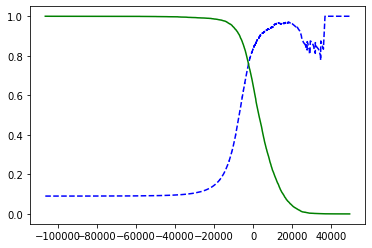

In [65]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict( sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")
precisions, recalls, thresholds = precision_recall_curve( y_train_5, y_scores )

def plot_precision_recall_vs_threshold( precisions, recalls, thresholds ):
    plt.plot( thresholds, precisions[:-1], "b--", label="precision" )
    plt.plot( thresholds, recalls[:-1], "g-", label = "recall" )
    
plot_precision_recall_vs_threshold( precisions, recalls, thresholds )
plt.show()

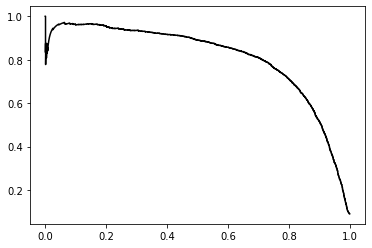

In [66]:
plt.plot( recalls[:-1], precisions[:-1] , "k-")

<br>

### ROC curve

**reciever operating characteristic curve** - plots true positive rate * False positive rate, or sensitivity * 1-specificity  
**area under the curve (AUC)** - one way to compare classifiers is by the AUC. A perfect classifier will have an ROC AUC == 1, whereas a completely random binary classifier will have an ROC AUC == 0.5.  

<br>

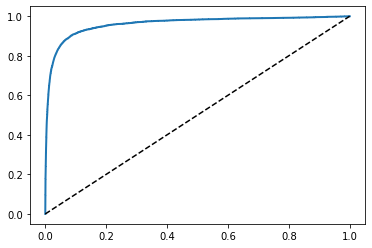

In [69]:
#plot the ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve( y_train_5, y_scores )
def plot_roc_curve( fpr, tpr, label = None ):
    plt.plot( fpr, tpr, linewidth = 2, label = label )
    plt.plot( [0,1], [0,1], 'k--')
    
plot_roc_curve( fpr, tpr )
plt.show()

In [70]:
#find the AUC
from sklearn.metrics import roc_auc_score
roc_auc_score( y_train_5, y_scores )

0.9604938554008616

In [72]:
# train a random forest classifier and compare the ROC/AUC with the SGD classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier( random_state = 42 )
y_probas_forest = cross_val_predict( forest_clf, X_train, y_train_5, cv=3, method= "predict_proba" )

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve( y_train_5, y_scores_forest )

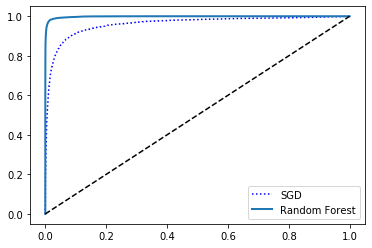

In [75]:
plt.plot( fpr, tpr, "b:", label = 'SGD')
plot_roc_curve( fpr_forest, tpr_forest, label = "Random Forest")
plt.legend( loc = "lower right" )
plt.show()

In [76]:
roc_auc_score( y_train_5, y_scores_forest )

0.9983436731328145

<br>

### Multiclass Classification

* **one-vs-all/rest (OvR)** - train binary classifiers for each class, get decision scores from each classifier and return the class that corresponds to the best value
* **one-vs-one (OvO)** - need $N \cdot (N-1) /2$ classifiers to distinguish between pairs of classes. chose the winner of most comarisons.

<br>

In [78]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit( X_train, y_train )
svm_clf.predict( [ some_digit ] )

array([1], dtype=uint8)

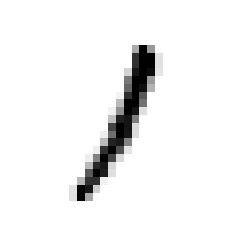

In [79]:
some_digit_image = some_digit.reshape( 28, 28 )

plt.imshow( some_digit_image, cmap = "binary" )
plt.axis( 'off' )
plt.show()

In [81]:
some_digit_scores = svm_clf.decision_function([some_digit])
print( some_digit_scores )
print( np.argmax( some_digit_scores ) )
print( svm_clf.classes_ )

[[-0.30727308  9.31003099  6.22374339  3.09511851  6.15897488  1.71471474
   0.69542629  8.29964841  4.12604772  6.22776651]]
1
[0 1 2 3 4 5 6 7 8 9]


In [82]:
# specify OvR
from sklearn.multiclass import OneVsRestClassifier
some_digit = X[36]
ovr_clf = OneVsRestClassifier( SVC() )
ovr_clf.fit( X_train, y_train )

NameError: name 'somedigit' is not defined

In [83]:
ovr_clf.predict([some_digit])

array([6], dtype=uint8)

In [91]:
#can also train the SDGClassifier
#sdg_clf = 
sgd_clf.fit( X_train, y_train )
sgd_clf.predict([some_digit])

array([6], dtype=uint8)

In [92]:
sgd_clf.decision_function([some_digit])

array([[-55723.18404806, -20277.71791818,  -3736.27195493,
         -8007.95082389, -13861.24096739,  -8747.27028356,
          5032.8587293 , -44464.31319087,  -1145.95291205,
        -15732.06327288]])

In [93]:
cross_val_score( sgd_clf, X_train, y_train, cv=3, scoring='accuracy' )

array([0.87365, 0.85835, 0.8689 ])

In [95]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform( X_train.astype( np.float64 ) )
cross_val_score( sgd_clf, X_train_scaled, y_train, cv=3, scoring = 'accuracy' )

array([0.8983, 0.891 , 0.9018])

<br>

### Error Analysis

what types of error does the model make?

<br>

In [96]:
y_train_pred = cross_val_predict( sgd_clf, X_train, y_train, cv = 3 )
conf_mx = confusion_matrix( y_train, y_train_pred )
conf_mx

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]])

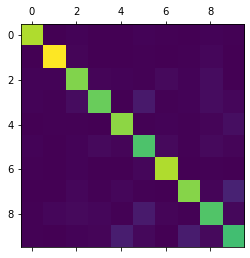

In [97]:
plt.matshow( conf_mx )
plt.show()

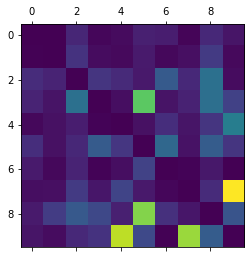

In [98]:
#focus on just the errors
row_sums = conf_mx.sum( axis = 1, keepdims = True )
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal( norm_conf_mx, 0)
plt.matshow( norm_conf_mx )
plt.show()

<br>

3s and 5s get mixed up.  
4s and 9s get mixed up.  
7s and 9s get mixed up.  
many numbers seem to get misclassified as 8, but 8s generally get correctly classified

<br>

In [99]:
# visualize some of the 3s and 5s
cl_a, cl_b = 3, 5
X_aa = X_train[ (y_train == cl_a ) & (y_train_pred == cl_a)]
X_ab = X_train[ (y_train == cl_a ) & (y_train_pred == cl_b)]
X_ba = X_train[ (y_train == cl_b ) & (y_train_pred == cl_a)]
X_bb = X_train[ (y_train == cl_b ) & (y_train_pred == cl_b)]

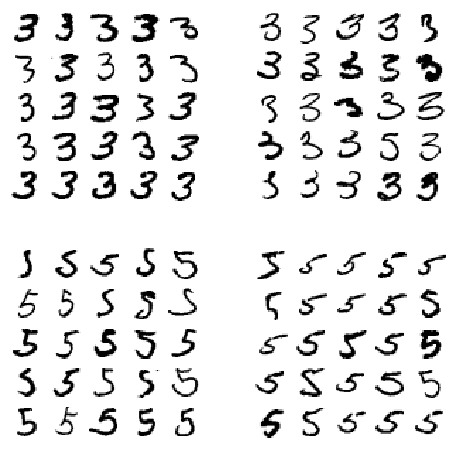

In [103]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
plt.figure( figsize = (8,8) )
plt.subplot(221); plot_digits( X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits( X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits( X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits( X_bb[:25], images_per_row=5)

<br>

### Multilabel Classification

<br>

In [104]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = ( y_train >= 7 )
y_train_odd = ( y_train % 2 == 1 )
y_multilabel = np.c_[ y_train_large, y_train_odd ]

knn_clf = KNeighborsClassifier()
knn_clf.fit( X_train, y_multilabel )

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [105]:
knn_clf.predict([some_digit])

array([[False, False]])

In [107]:
y_train_knn_pred = cross_val_predict( knn_clf, X_train, y_multilabel, cv = 3 )
f1_score( y_multilabel, y_train_knn_pred, average='macro')

KeyboardInterrupt: 

In [ ]:
f1_score( y_multilabel, y_train_knn_pred, average='weighted')

<br>

## Chapter 4: Training Models

<br>

In many situations, you don't need to know the implementation details  
However, having a good understanding oh how things work can help you quickly home in on the appropriate model, the right training algorithm to use and a good set of hyperparameters for your task  

* **closed-form** - directly compute model parameters that best fit the model to the training set
* **iterative optimization** - gradually tweak model parameters to minimize the cost function over the training set  

### Linear Regression

training a model means setting its parameters so that the model best fits the training set. (ex: for Linear Regression: find the value that minimizes the RMSE, or in practice the MSE)  
$$\mbox{MSE}(\mathbf{X},h_{\theta}) = \frac{1}{m} \sum^m_{i=1}(\mathbf{\theta}^T \mathbf{x}^{(i)}-y^{(i)})^2$$

**closed-form** solution: *Normal Equation* $\hat{ \mathbf{ \theta }} = (\mathbf{X}^T \mathbf{X})^{-1} \cdot \mathbf{X}^T \mathbf{y}$

<br>

In [17]:
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.randn( 100, 1 )
y = 4 + 3 * X + np.random.randn( 100, 1 )

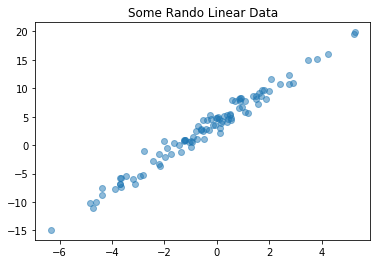

In [18]:
plt.scatter(X, y, alpha=0.5)
plt.title( "Some Rando Linear Data")
plt.show()

In [19]:
# compute theta_hat using the Normal Equation
X_b = np.c_[ np.ones((100,1)),X]
theta_best = np.linalg.inv( X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.09438671],
       [2.9296006 ]])

In [20]:
#make predictions using theta_hat
X_new = np.array( [[0],[2]] )
X_new_b = np.c_[ np.ones((2,1)), X_new ]
y_predict = X_new_b.dot( theta_best )
y_predict

array([[4.09438671],
       [9.9535879 ]])

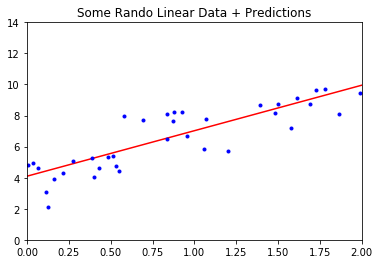

In [22]:
plt.plot( X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.title( "Some Rando Linear Data + Predictions")
plt.ylim( 0, 14 )
plt.xlim( 0, 2 )
plt.show()

In [23]:
# performing linear regression is simple with sklearn:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit( X, y )
print( lin_reg.intercept_, lin_reg.coef_ )
lin_reg.predict( X_new )

[4.09438671] [[2.9296006]]


array([[4.09438671],
       [9.9535879 ]])

<br>

**gradiant descent** - tweak parameters iteratively in order to minimize a cost function. GD measures the local gradient of the error functionwith regard to the parameter vector $\theta$, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum (convergence).  

**learning rate** - the size of the steps that the gradient descent takes while tweaking parameters. learning rate is a **hyperparameter**. Training a model means searching for a combinations of model parameters (hyperpaprameters) that minimizes a cost function  

when using gradient descent, you should ensure that all features have a similar scale, or else it will take much longer to converge.  

**partial derivative** - caluclate how much the value (cost function) changes if you change $\theta$ just a little bit  

partial derivative of the cost function: $$\frac{\partial}{\partial \theta_j}\mbox{MSE}(\mathbf{\theta}) = \frac{2}{m}\sum^m_{i=1}(\mathbf{\theta}^T\mathbf{x}^{(i)}-y^{(i)})x_j^{(i)} $$

**batch gradient descent** - calculattions over the full training set at each gradient descent step

<br>

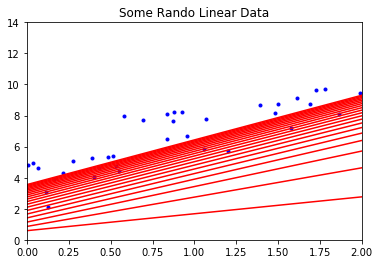

In [32]:
# implement batch gradient descent
eta = 0.1 #learnign rate
n_iterations = 20
m = 100


plt.plot(X, y, "b.")
plt.title( "Some Rando Linear Data")
plt.ylim( 0, 14 )
plt.xlim( 0, 2 )


theta  = np.random.randn( 2,1 )

for iteration in range( n_iterations ):
    gradients = 1/m*X_b.T.dot( X_b.dot( theta ) -y )
    theta = theta - eta * gradients
    y_predict = X_new_b.dot( theta )
    plt.plot( X_new, y_predict, "r-")
    
plt.show()

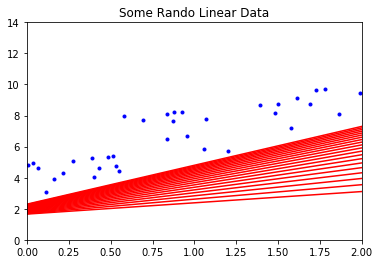

In [33]:
# implement batch gradient descent
eta = 0.02 #learnign rate
n_iterations = 20
m = 100


plt.plot(X, y, "b.")
plt.title( "Some Rando Linear Data")
plt.ylim( 0, 14 )
plt.xlim( 0, 2 )


theta  = np.random.randn( 2,1 )

for iteration in range( n_iterations ):
    gradients = 1/m*X_b.T.dot( X_b.dot( theta ) -y )
    theta = theta - eta * gradients
    y_predict = X_new_b.dot( theta )
    plt.plot( X_new, y_predict, "r-")
    
plt.show()

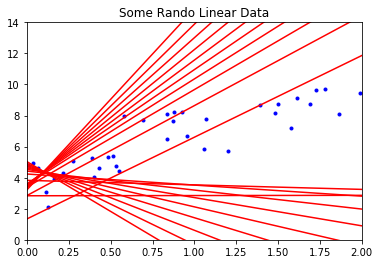

In [34]:
# implement batch gradient descent
eta = 0.4 #learnign rate
n_iterations = 20
m = 100


plt.plot(X, y, "b.")
plt.title( "Some Rando Linear Data")
plt.ylim( 0, 14 )
plt.xlim( 0, 2 )


theta  = np.random.randn( 2,1 )

for iteration in range( n_iterations ):
    gradients = 1/m*X_b.T.dot( X_b.dot( theta ) -y )
    theta = theta - eta * gradients
    y_predict = X_new_b.dot( theta )
    plt.plot( X_new, y_predict, "r-")
    
plt.show()

<br>

**stochastic gradient descent** - picks a random instance in the training set at every step and computes the gradients based only on a single instance  

shuffle the data to ensure that the training instances are independent, otherwise SGD might not converge on the global minimum

<br>

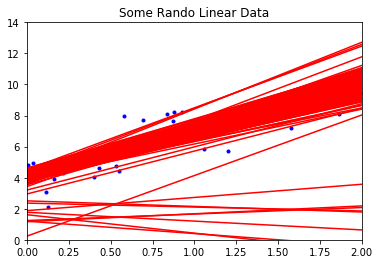

In [35]:
plt.plot(X, y, "b.")
plt.title( "Some Rando Linear Data + Stochastic Gradient Descent")
plt.ylim( 0, 14 )
plt.xlim( 0, 2 )


n_epochs = 50
t0, t1 = 5, 50

def learning_schedule( t ):
    return t0 / ( t + t1 )

theta = np.random.randn( 2,1 )

for epoch in range( n_epochs ):
    for i in range( m ):
        random_index = np.random.randint( m )
        xi = X_b[ random_index : random_index + 1 ]
        yi = y[ random_index : random_index + 1 ]
        gradients = 2 * xi.T.dot( xi.dot( theta ) - yi )
        eta = learning_schedule( epoch * m + i )
        theta = theta - eta * gradients
        y_predict = X_new_b.dot( theta )
        plt.plot( X_new, y_predict, "r-")
        
plt.show()

In [37]:
#stochastic gradient descent by sklearn
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor( max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1 )
sgd_reg.fit( X, y.ravel() )
print( sgd_reg.intercept_, sgd_reg.coef_ )

[3.98008106] [2.94971262]


<br>

**mini-batch gradient descent** - compute the gradients on small random sets of instances called mini-batches  

Comparison of some algorithms used for Linear Regression:  

| **Algorithm**           | **Large m** | **Out-of-core support** | **Large n** | **Hyperparameters** | **Scaling required** | **Scikit-Learn** |
|-------------------------|-------------|-------------------------|-------------|---------------------|----------------------|------------------|
| **Normal Equation**     |     Fast    |            No           |     Slow    |          0          |          No          |        N/A       |
| **Singular Val Decomp** |     Fast    |            No           |     Skow    |          0          |          No          | LinearRegression |
| **Batch GD**            |     Slow    |            No           |     Fast    |          2          |          Yes         |   SGDRegressor   |
| **Stochastic GD**       |     Fast    |           Yes           |     Fast    |        $\ge$2       |          Yes         |   SGDRegressor   |
| **Mini-Batch GD**       |     Fast    |           Yes           |     Fast    |        $\ge$2       |          Yes         |   SGDRegressor   |

<br>

### Polynomial Regression

you can use a linear model to fit nonlinear data

<br>

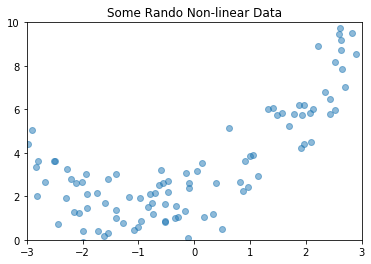

In [40]:
# generate some quadratic nonlinear data
m = 100
X = 6 * np.random.rand( m, 1 ) - 3 
y = 0.5 * X**2 + X + 2 + np.random.randn( m,1 )

plt.scatter(X, y, alpha=0.5)
plt.title( "Some Rando Non-linear Data")
plt.xlim( -3, 3 )
plt.ylim( 0, 10 )
plt.show()

<br>

add the square of each feature in the training set as a new feature. then, fit a `LinearRegression` model

<br>

In [47]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures( degree = 2, include_bias = False )
X_poly = poly_features.fit_transform( X )

lin_reg = LinearRegression()
lin_reg.fit( X_poly, y )
print( lin_reg.intercept_, lin_reg.coef_ )

[1.92915937] [[1.02768411 0.50995224]]


In [52]:
y_predict = lin_reg.predict( X_poly )

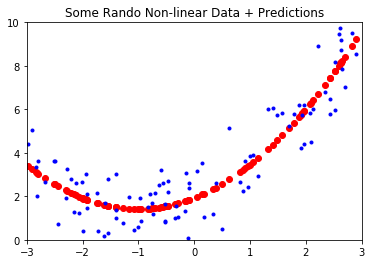

In [55]:
plt.plot( X,y_predict, "ro")
plt.plot(X, y, "b.")
plt.title( "Some Rando Non-linear Data + Predictions")
plt.xlim( -3, 3 )
plt.ylim( 0, 10 )
plt.show()

<br>

In general, you won't know the function that generated the data, so how can you decide how complex your model should be? How can you tell that your model is overfitting or underfitting the data?  

**learning curves** - plots of the model's performance on the training set and the validation set as a function of the training set size

<br>

In [58]:
# learning curve for LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves( model, X, y ):
    X_train, X_val, y_train, y_val = train_test_split( X, y, test_size = 0.2 )
    train_errors, val_errors = [], []
    for m in range( 1, len( X_train ) ):
        model.fit( X_train[ :m ], y_train[ :m ] )
        y_train_predict = model.predict( X_train[ :m ] )
        y_val_predict = model.predict( X_val )
        train_errors.append( mean_squared_error( y_train[ :m ], y_train_predict ) )
        val_errors.append( mean_squared_error( y_val, y_val_predict ) )
    plt.plot( np.sqrt( train_errors ), 'r-+', linewidth=2, label='train' )
    plt.plot( np.sqrt( val_errors ), 'b-', linewidth=2, label='val' )

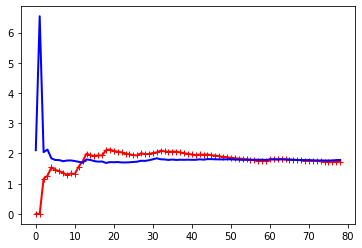

In [59]:
lin_reg = LinearRegression()
plot_learning_curves( lin_reg, X, y )

<br>

the above curves are typical of a model that is underfitting: both curves have reached a plateau, they are close and fairly high. If your model is underfitting the training data, adding more training exambles will not help. You need to use a more complex model or come up with better features.  

<br>

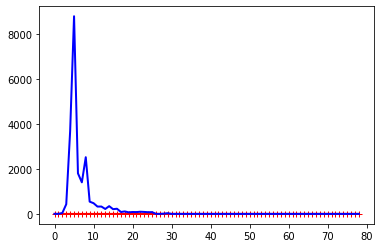

In [63]:
# look at the learning curves of a 10 deg polynomial
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline( [
    ("poly_features", PolynomialFeatures( degree=10, include_bias = False ) ),
    ("lin_reg", LinearRegression() ),
])

plot_learning_curves( polynomial_regression, X, y )

<br>

notice that the error on the training data is a lot lower than it was for LinearRegression. there is also a big gap between the performance on the training data and on the validation data.  

one way to improve an overfitting model is to feed it more training data until the validation error reaches the training error  

<br>

**Bias/Variance Trade-Off**  

a model's generalization error can be expressed as the sum of three very different errors:  

1. **Bias** - due to wrongness of assumptions (e.g assuming a linear model). will most likely underfit
2. **Variance** - due to the model's excessive sensitivity to variations in the training data. will likely overfit
3. **Irreducible Error** - due to noise inherent in the data  

increasing a model's complexity will typically increase it's variance and reduce it's bias. Conversely, reducing a model's complexity increases it's bias and reduces it's variance.  

<br>

### Regularized Linear Models

constrain the weights of the model such that the model has fewer degrees of freedom  

**Ridge Regression** - a regularization term is added to the cost function which froces the learning algorithm to not only fit the data, but also keep the model weights as small as possible.  
$$\mbox{J}(\theta) = \mbox{MSE}(\theta) + \alpha \frac{1}{2} \sum_{i=1}^n \theta_i^2$$

it is important to scale the data ( e.g. with `StandardScaler` ) before performing Ridge Regression, as it is sensitive to the scale of the input features

<br>

In [64]:
#ridge regression using scikit-learnclosed-form:
from sklearn.linear_model import Ridge
ridge_reg = Ridge( alpha = 1, solver = 'cholesky' )
ridge_reg.fit( X,y )
ridge_reg.predict([[1.5]])

array([[5.0808239]])

In [68]:
#ridge regression by way of stochastic gradient descent:
sgd_ridge = SGDRegressor( penalty = 'l2' ) #add a regilarization term
sgd_ridge.fit( X, y.ravel() )
sgd_ridge.predict([[1.5]])

array([5.06731112])

<br>

**lasso regression** - Least Absolute Shrinkage and Selection Operator Regression. adds a regularization term to the cost function, but it uses the $\mathcal{l}_1$ norm of the weught vector instead of half the square of the $\mathcal{l}_2$ norm $$\mbox{J}(\theta) = \mbox{MSE}(\theta) + \alpha \sum_{i=1}^n |\theta_i|$$

tends to eliminate the weights of the least important features $\longrightarrow$ Lasso Regression automatically performs feature selection and outputs a sparse model

<br>

In [67]:
# a small Lasso Regression example with scikit-learn
from sklearn.linear_model import Lasso
lasso_reg = Lasso( alpha = 0.1 )
lasso_reg.fit( X,y )
lasso_reg.predict([[1.5]])

array([5.03318065])

In [69]:
#lasso regression by way of stochastic gradient descent:
sgd_lasso = SGDRegressor( penalty = 'l1' ) #add a regilarization term
sgd_lasso.fit( X, y.ravel() )
sgd_lasso.predict([[1.5]])

array([5.05539776])

<br>

**Elastic Net** - the regularization term is a simple mix of both Ridge and Lasso that is controlled by a mic ratio *r*: $$\mbox{J}(\theta) = \mbox{MSE}(\theta) + r\alpha \sum_{i=1}^n |\theta_i| + \alpha \frac{1-r}{2} \sum_{i=1}^n \theta_i^2$$

So when should you use plain Linear Regression (w/o regularization), Ridge, Lasso, or Elastic Net?: it is almost always preferable to have at least a little bit of regularization, so generally you should avoid plain Linear Regression. Ridge is a good default, but if you suspect that only a few features are useful, you should prefer Lasso or Elastic Net because they tend to reduce the useless features' weights down to zero. In general, Elastic Net is preferred over Lasso because Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

<br>

In [70]:
#elastic net short example:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet( alpha=0.1, l1_ratio = 0.5 )
elastic_net.fit( X,y )
elastic_net.predict([[1.5]])

array([5.03213402])

<br>

**Early Stopping** - stop training as soon as the validation error reaches a minimum.  ....a "beautiful free lunch" (-Geoffrey Hinton)  

<br>

In [83]:
#basic early stopping implementation:

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

#prepare the data
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size = 0.2 )
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures( degree = 90, include_bias = False ) ),
    ("std_scaler", StandardScaler() )
])

X_train_poly_scaled = poly_scaler.fit_transform( X_train )
X_val_poly_scaled = poly_scaler.transform( X_val )

sgd_reg = SGDRegressor( max_iter = 1, tol = -np.infty, warm_start = True,
                       penalty = None, learning_rate = 'constant', eta0 = 0.0005 )

minimum_val_error = float( "inf" )
best_epoch = None
best_model = None

for epoch in range( 1000 ):
    sgd_reg.fit( X_train_poly_scaled, y_train.ravel() )
    y_val_predict = sgd_reg.predict( X_val_poly_scaled )
    val_error = mean_squared_error( y_val, y_val_predict )
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone( sgd_reg )

In [84]:
print( str( best_epoch ) )
print( str( best_model ) )
print( str( minimum_val_error ) )

30
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
             warm_start=True)
3.9799252818280118


<br>

### Logistic Regression

**logistic (logit) regression** - used to estimate the probability that an instance belongs to a particular class
$$\hat{p} = h_{\theta}($\mathbf{x}) = \sigma ($\mathbf{x}^T $\mathbf{\Theta}$$

the logistic function, $\sigma()$ is a sigmoid function that outputs a number between 0 and 1
$$\sigma(t) = \frac{1}{1+\mbox{exp}(-t)}$$

once an estimate is made, a class prediction is determined as follows:
$$\hat{y} = \left\{ \begin{array}{rcl}
0 & \mbox{if}
& \hat{p} \lt 0.5 \\ 1 & \mbox{if} & \hat{p}\ge 0.5 
\end{array}\right.$$

cost function:
$$c(\Theta) = \left\{ \begin{array}{rcl}
-\mbox{log} (\hat{p}) & \mbox{if}
& y = 1 \\ -\mbox{log}(1-\hat{p}) & \mbox{if} & y = 0 
\end{array}\right.$$

**log-loss** - the cost function over the whole training set is the average cost over the training instances

<br>

In [87]:
# logistic regression for classification with the iris data set
from sklearn import datasets
iris = datasets.load_iris()
list( iris.keys() )
X = iris['data'][:,3].reshape(-1, 1)
y = ( iris['target']==2 ).astype( np.int )

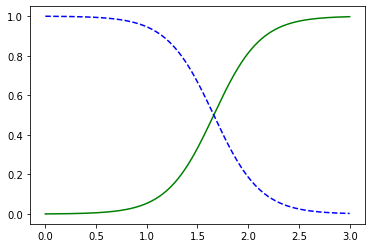

In [88]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit( X,y )

X_new = np.linspace( 0,3,1000 ).reshape( -1,1 )
y_proba = log_reg.predict_proba( X_new )
plt.plot( X_new, y_proba[:,1], 'g-', label = 'Iris virginica' )
plt.plot( X_new, y_proba[:,0], 'b--', label = 'Not Iris virginica' )

<br>

**Softmax | Multinomial Logistic Regression** - a generalized form of logistic regression that can support multiple classes.

<br>

In [90]:
X = iris['data'][:,(2,3)]
y = iris['target']

softmax_reg = LogisticRegression( multi_class = 'multinomial', solver = 'lbfgs', C=10 )
softmax_reg.fit( X,y )
print( softmax_reg.predict([[ 5,2 ]]) )
softmax_reg.predict_proba([[5,2]])

[2]


array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])